# **Biomedical image preprocessing**

**Histogram Equalization**

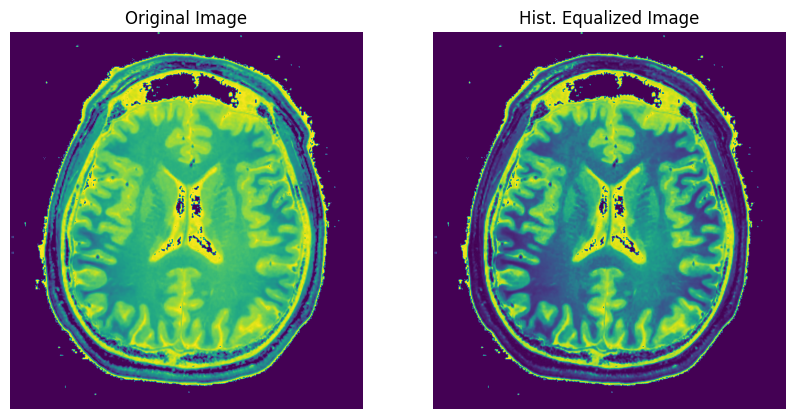

In [3]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt # library used for visualization in the notebook
import matplotlib.image as mpimg # library used for visualization in the notebook
    
# calculates normalized histogram of an image
def imhist(im):
	m, n = im.shape
	h = [0.0] * 256
	for i in range(m):
		for j in range(n):
			h[im[i, j]]+=1
	return np.array(h)/(m*n)

def cumsum(h):
	# finds cumulative sum of a numpy array, list
	return [sum(h[:i+1]) for i in range(len(h))]

def histeq(im):
	#calculate Histogram
	h = imhist(im)
	cdf = np.array(cumsum(h)) #cumulative distribution function
	sk = np.uint8(255 * cdf) #finding transfer function values
	s1, s2 = im.shape
	Y = np.zeros_like(im)
	# applying transfered values for each pixels
	for i in range(0, s1):
		for j in range(0, s2):
			Y[i, j] = sk[im[i, j]]
	H = imhist(Y)
	return Y , h, H, sk

img = np.uint8(mpimg.imread('MRI.jpg')*255.0)

#this is about to apply a contrast manipulation, coefficients shoudl be 
#get from histogram analyis
img = np.uint8((0.2126* img[:,:,0]) + \
  		np.uint8(0.7152 * img[:,:,1]) +\
			 np.uint8(0.0722 * img[:,:,2]))

new_img, h, new_h, sk = histeq(img)


# plot histograms and transfer function
#fig = plt.figure()
#fig.add_subplot(131)
#plt.plot(h)
#plt.title('Original Histogram') # original histogram

#fig.add_subplot(132)
#plt.plot(new_h)
#plt.title('New Histogram') #hist of eqlauized image

#fig.add_subplot(133)
#plt.plot(sk)
#plt.title('Transfer Function') #transfer function
#plt.set_cmap('gray')
#plt.show()


# show old and new image
# show original image
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

# show original image
plt.subplot(122)
plt.imshow(new_img)
plt.title('Hist. Equalized Image')
plt.axis('off')
plt.show()

# **Denoising**

**Median Filter**

In [7]:
def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = []
    data_final = np.zeros((len(data),len(data[0])))
    for i in range(len(data)):

        for j in range(len(data[0])):

            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final

In [9]:
# Load the image, converts the image to grayscale (mode "L" stands for "luminance").
img = Image.open("MRI.jpg").convert("L")

#noise definition - used just to demonstrate the effectiveness of the filter, do not
#propagate this function in the final code for Knime
def add_salt_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    # Convert the image to a numpy array
    arr = np.array(image)
    
    # Generate random values for salt and pepper noise
    salt_mask = np.random.rand(*arr.shape) < salt_prob
    pepper_mask = np.random.rand(*arr.shape) < pepper_prob
    
    # Apply salt noise (white pixels)
    arr[salt_mask] = 255
    
    # Apply pepper noise (black pixels)
    arr[pepper_mask] = 0
    
    # Convert the array back to an image
    noisy_image = Image.fromarray(arr)
    return noisy_image

# Add salt and pepper noise
noisy_img = add_salt_pepper_noise(img, salt_prob=0.1, pepper_prob=0.1)
arr = np.array(noisy_img, dtype=np.uint8)

noisy_img.save('MRI_noise.png')
noisy_img.transpose(Image.TRANSPOSE).save('MRI_noise2.png')


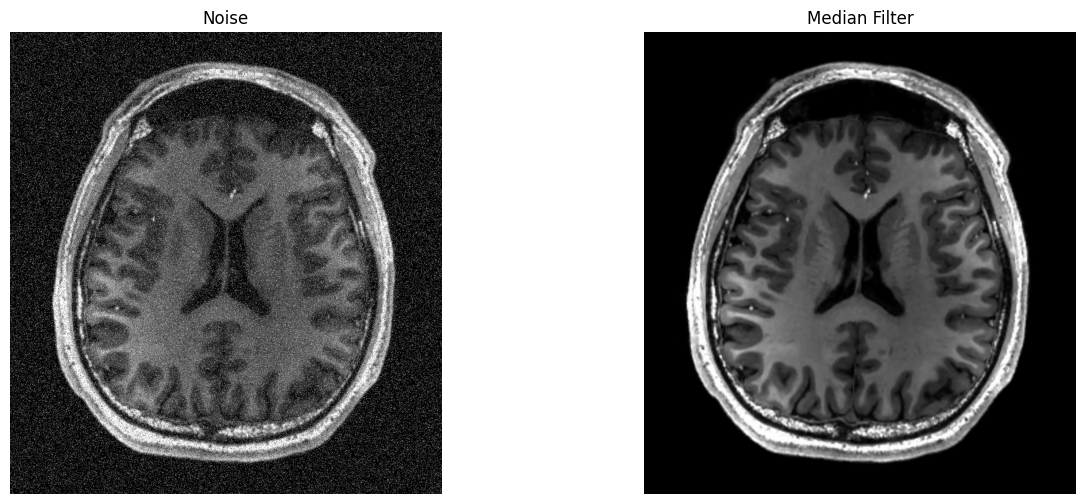

In [8]:

# Apply median filter to remove noise
removed_noise = median_filter(arr, 5)
img1 = Image.fromarray(removed_noise)

# Plot the original and filtered images
# from here on no need to put the code in knime, used just for visualization
plt.figure(figsize=(15,6))

# Display the original noisy image
plt.subplot(121)
plt.title("Noise")
plt.imshow(noisy_img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

# Display the filtered image with grayscale colormap
plt.subplot(122)
plt.title("Median Filter")
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.show()

**Averaging Filter**

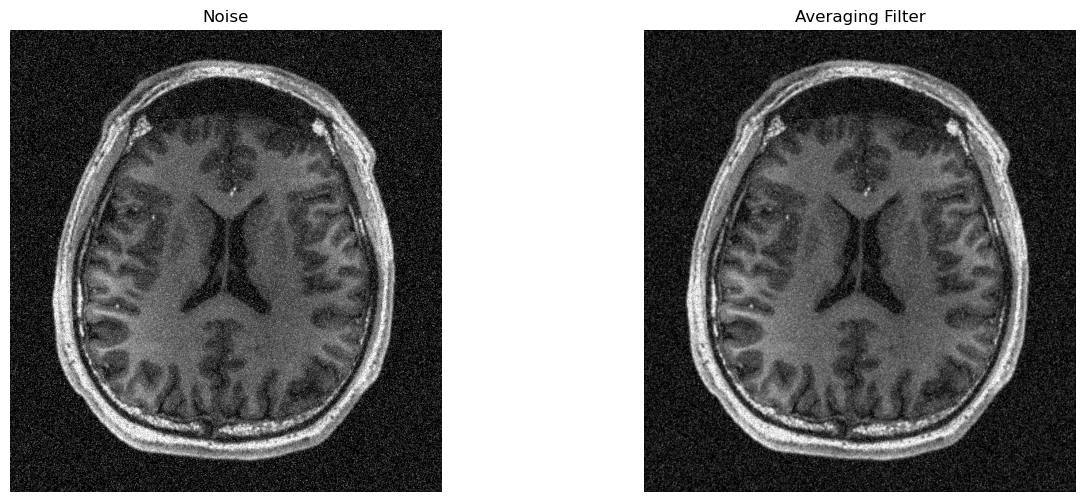

In [10]:
# Read the image

img_original = Image.open("MRI.jpg").convert("L")

# This is just for definition of noise, do not replicate it in the Knime version
def add_gaussian_noise(image, mean=0, std=25):
    # Convert the image to a numpy array
    arr = np.array(image, dtype=np.float32)
    
    # Generate Gaussian noise
    gaussian_noise = np.random.normal(mean, std, arr.shape)
    
    # Add the noise to the image
    noisy_arr = arr + gaussian_noise
    
    # Clip values to stay within valid range (0 to 255) and convert back to uint8
    noisy_arr = np.clip(noisy_arr, 0, 255).astype(np.uint8)
    
    # Convert the array back to an image
    noisy_image = Image.fromarray(noisy_arr)
    return noisy_image

img_noise = add_gaussian_noise(img_original, mean=0, std=25)
img = np.array(noisy_img, dtype=np.uint8)
m, n = img.shape

# Develop Averaging filter(3, 3) mask
mask = np.ones([3, 3], dtype = int)
mask = mask / 9

# Convolve the 3X3 mask over the image
img_new = np.zeros([m, n])

for i in range(1, m-1):
	for j in range(1, n-1):
		temp = img[i-1, j-1]*mask[0, 0]+img[i-1, j]*mask[0, 1]+img[i-1, j + 1]*mask[0, 2]+img[i, j-1]*mask[1, 0]+ img[i, j]*mask[1, 1]+img[i, j + 1]*mask[1, 2]+img[i + 1, j-1]*mask[2, 0]+img[i + 1, j]*mask[2, 1]+img[i + 1, j + 1]*mask[2, 2]
		
		img_new[i, j]= temp
		
img_new = img_new.astype(np.uint8)

# This is just for visualization in the notebook
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title("Noise")
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.set_cmap('gray')
plt.imshow(img)
plt.subplot(122)
plt.title("Averaging Filter")
plt.imshow(img_new, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.set_cmap('gray')
plt.imshow(img_new)


# Edge detection

robert operator, sobel operator, and laplace operator for image sharpening and edge detection

In [32]:
# in this notebook we use opencv instead of PIL to open images
# robert operator [[-1,-1],[1,1]]
def robert(img):
    r, c = img.shape
    r_sunnzi = [[-1,-1],[1,1]]
    for x in range(r):
        for y in range(c):
            if (y + 2 <= c) and (x + 2 <= r):
                imgChild = img[x:x+2, y:y+2]
                list_robert = r_sunnzi*imgChild
                new_img[x, y] = abs(list_robert.sum()) # sum and absolute value
    return np.uint8(new_img)
                 
 # # The implementation of sobel operator
def sobel(img):
    r, c = img.shape
    new_image = np.zeros((r, c))
    new_imageX = np.zeros(img.shape)
    new_imageY = np.zeros(img.shape)
    s_suanziX = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) # X direction
    s_suanziY = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])     
    for i in range(r-2):
        for j in range(c-2):
            new_imageX[i+1, j+1] = abs(np.sum(img[i:i+3, j:j+3] * s_suanziX))
            new_imageY[i+1, j+1] = abs(np.sum(img[i:i+3, j:j+3] * s_suanziY))
            new_image[i+1, j+1] = (new_imageX[i+1, j+1]*new_imageX[i+1,j+1] + new_imageY[i+1, j+1]*new_imageY[i+1,j+1])**0.5

    return np.uint8(new_image) # The image processed by the directionless operator
 
# Laplace operator
def laplace(img):
    r, c = img.shape
    new_image = np.zeros((r, c))
    L_sunnzi = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])          
    for i in range(r-2):
        for j in range(c-2):
            new_image[i+1, j+1] = abs(np.sum(img[i:i+3, j:j+3] * L_sunnzi))
    return np.uint8(new_image)
 
 
img = cv2.imread('MRI.jpg', cv2.IMREAD_GRAYSCALE)
img_laplace = laplace(img)
img_robert = robert(img)
img_sobel = sobel(img)



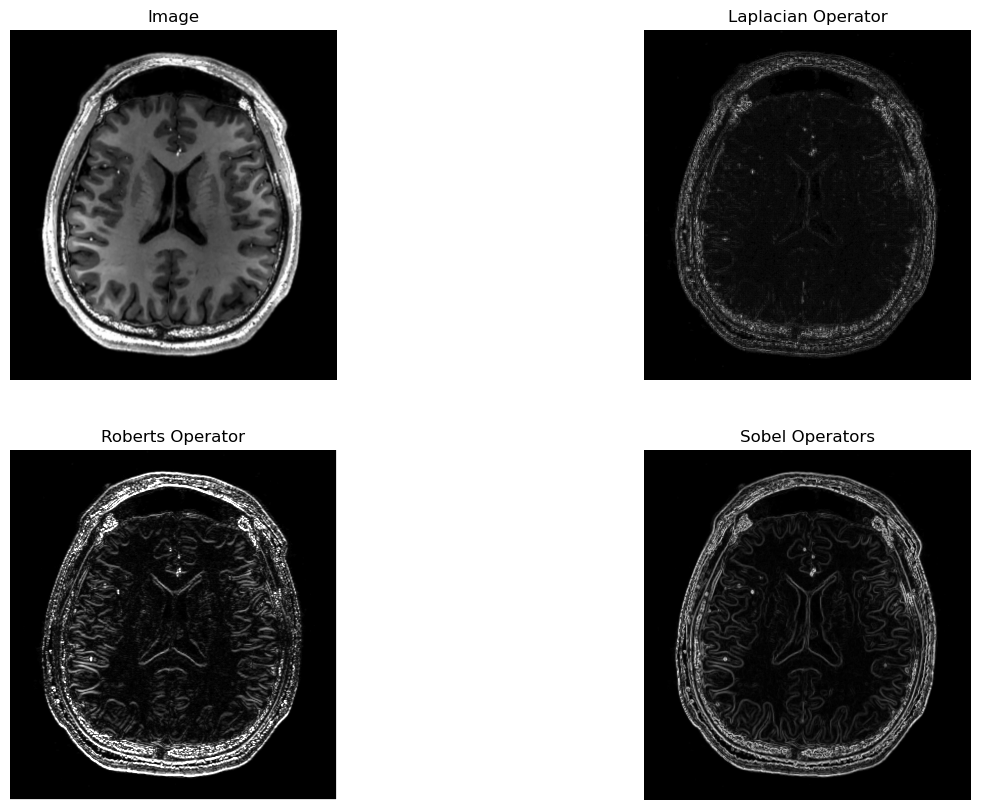

In [38]:
# from here on is just about applying filters and visualization
 
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.title("Image")
plt.imshow(img, cmap="gray", vmin=0, vmax=100)
plt.axis('off')
plt.set_cmap('gray')
plt.imshow(img)

plt.subplot(222)
plt.title("Laplacian Operator")
plt.imshow(img_laplace, cmap="gray", vmin=np.min(img_laplace), vmax=30)
#plt.imshow(img_laplace, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.set_cmap('gray')

plt.subplot(223)
plt.title("Roberts Operator")
#plt.imshow(img_robert, cmap="gray", vmin=0, vmax=255)
plt.imshow(img_robert, cmap="gray", vmin=np.min(img_robert), vmax=30)
plt.axis('off')
plt.set_cmap('gray')

plt.subplot(224)
plt.title("Sobel Operators")
#plt.imshow(img_sobel, cmap="gray", vmin=0, vmax=255)
plt.imshow(img_sobel, cmap="gray", vmin=np.min(img_sobel), vmax=np.max(img_sobel))
plt.axis('off')
plt.set_cmap('gray')